<a href="https://colab.research.google.com/github/marcosw1998/Data-Science/blob/main-igor/Analysis_Notebook/covid_spends_brazil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise dos custos do governo de Pernambuco - BR em relação à Covid-19
* Projeto corresponde a entrega parcial para avaliação na cadeira eletiva IF697 - Intro. a Ciência dos Dados
* Autores: Igor Silva e Marcos Cavalcanti
* Conjunto de dados públicos retirados das seguintes fontes:
  * [Portal da Transparência TCU](http://www.portaltransparencia.gov.br/coronavirus)
  * [Prefeitura do Recife](http://dados.recife.pe.gov.br/dataset?tags=sa%C3%BAde)
  * [Brasil.io](https://brasil.io/dataset/covid19/caso_full/)



## Por quê o tema?

* Interesse em entender e expor de forma clara os gastos públicos
* Analisar distribuição de gastos
* Covis-19 é um tema importante e merece muita atenção, pois tem feito muitas vítimas e mudado a forma como a sociedade pensa e se organiza
* Entender a distribuição de gastos é uma boa forma de tentar corrigir erros e minimizar danos futuros na economia e na sociedade

## Carregando as bibliotecas

  * Utilizaremos a biblioteca ***`Pandas`*** para trabalhar sobre os dados  e a biblioteca ***`Numpy`*** para geração de gráficos.
  



In [1]:
import numpy as np
import pandas as pd

In [2]:
!pip install pyspark

     |████████████████████████████████| 212.3MB 65kB/s 
     |████████████████████████████████| 204kB 13.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=8d66d3a6e3d18ce59a82be0bb8ac47174debfcf918c60a611db19f0927a14afa
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark


In [3]:
import pyspark
from pyspark import SparkContext
sc = SparkContext("local", "first app")

## Carregando os dados

  * Utilizaremos a lib ***`requests`*** para carregar os dados em formato csv e em seguida convertê-los em JSON
  * Referência: https://www.nylas.com/blog/use-python-requests-module-rest-apis/ 
  * Instalação
     ```
      !pip install requests
      ```



In [ ]:
!pip install requests

### Portal da transparência

* O portal da transparência permite que sejam baixados apenas 1000 registros por vez, portanto decidimos por baixar 2 datasets diferentes e depois fazermos a junção. Os dados são referentes a algumas cidades de Pernambuco 
(Recife, Jaboatão, Olinda, Paulista, Caruaru, Garanhuns, Petrolina, Arcoverde, Serra Talhada, Buíque)

In [96]:
invest_covidPe = pd.read_csv("https://raw.githubusercontent.com/marcosw1998/Data-Science/main-mwac/Datasets/covid-pe.csv",encoding = "utf-8")
invest_covidPe2 = pd.read_csv("https://raw.githubusercontent.com/marcosw1998/Data-Science/main-mwac/Datasets/transferencias_coronavirus.csv",encoding = "utf-8")

In [97]:
#Validando os dados do dataset invest_covidPe
print('Dataset 1',invest_covidPe.shape)
invest_covidPe.sort_values("Município").head()

Dataset 1 (561, 12)


Mês/Ano  ... Valor Transferido
182  nov/20  ...        486.515.00
178  nov/20  ...          7.897.02
179  nov/20  ...          2.837.48
87   nov/20  ...          8.427.56
181  nov/20  ...          2.274.59

[5 rows x 12 columns]

In [98]:
#Validando os dados do dataset invest_covidPe2
print('Dataset 2',invest_covidPe2.shape)
invest_covidPe2.sort_values("Município").head()

Dataset 2 (140, 10)


Mês/Ano                               Tipo  ... Valor Transferido Unnamed: 9
98  12/2020  Legais. Voluntárias e Específicas  ...     R$ 134.639.00        NaN
41  05/2020  Legais. Voluntárias e Específicas  ...     R$ 470.809.62        NaN
42  11/2020  Legais. Voluntárias e Específicas  ...     R$ 355.594.00        NaN
32  04/2020  Legais. Voluntárias e Específicas  ...     R$ 761.895.71        NaN
56  08/2020  Legais. Voluntárias e Específicas  ...     R$ 218.971.54        NaN

[5 rows x 10 columns]

*Podemos perceber que o Dataset **invest_covidPe** possui mais colunas que o Dataset **invest_covidPe2**.  Também notamos que o Dataset invest_covidPe2 possui uma coluna com dados Nan, vamos tratar disso no pré processamento antes de fazer a concatenação dos dois Datasets*

### Dados abertos - Prefeitura do Recife

In [7]:
import requests

dados_pref_rmr = requests.get("http://dados.recife.pe.gov.br/dataset/6c77a814-7161-4eb5-9662-234642dc8cc1/resource/63376b8c-0271-42eb-a88b-cc75c1c3f3fc/download/metadados-hospitais.json").json()

### Dados de casos de Covid-19 por todo o estado de Pernambuco. 
Os valores estão atualizados até o dia 17/03/2021 e foram buscados através do Brasil.io

In [99]:
covidPeCases = pd.read_csv("https://raw.githubusercontent.com/marcosw1998/Data-Science/main-mwac/Datasets/covid19-1703-casos.csv",encoding = "utf-8")
print(covidPeCases.shape)
covidPeCases.sort_values("city").head()

(187, 16)


epidemiological_week        date  ...  is_last is_repeated
1                202111  2021-03-15  ...     True       False
2                202111  2021-03-15  ...     True       False
3                202111  2021-03-15  ...     True       False
4                202111  2021-03-15  ...     True       False
7                202111  2021-03-15  ...     True       False

[5 rows x 16 columns]

## **Pré Processamento**
  * Junção de datasets em Dataframe Pandas
  * Tratamento de dados ```NaN```/```null``` ou corrompidos
  * Conversão de tipos
  * Transformação e identificação de dados categóricos
  * Remoção de ***Outliers*** Multivariado

### **Dados sobre investimentos do governo**

In [ ]:
# Verificando se existem registros duplicados
print("Número de registros duplicados")
print("Dataset 1",len(invest_covidPe[invest_covidPe.duplicated()]))
print("Dataset 2",len(invest_covidPe2[invest_covidPe2.duplicated()]))


Número de registros duplicados
Dataset 1 25
Dataset 2 0


In [ ]:
#Checando se temos valores Nan
print('Dataset 1',invest_covidPe.isnull().sum())
print('Dataset 1',invest_covidPe2.isnull().sum())

Dataset 1 Mês/Ano                  0
Tipo                     0
Tipo de Favorecido       0
UF                       0
Município                0
Função                   0
Programa Orçamentário    0
Ação Orçamentária        0
Valor Transferido        0
valores_transferidos     0
dtype: int64
Dataset 1 Mês/Ano                  0
Tipo                     0
Ação Orçamentária        0
Programa Orçamentário    0
Função                   0
Tipo de Favorecido       0
UF                       0
Município                0
Valor Transferido        0
dtype: int64


### **Limpeza do conjunto de dados**

In [100]:
#Dropando colunas que não fazem parte do dataset invest_covidPe2 e que não influem sobre os nossos estudos (Nome do favorecido, CPF/CNPJ, Linguagem Cidadã)
#invest_covidPe = invest_covidPe.dropna(axis=1, how='all')
cols = [4,5,10]
invest_covidPe.drop(invest_covidPe.columns[cols],axis=1,inplace=True)
invest_covidPe.sort_values("Município").head()

Mês/Ano  ... Valor Transferido
182  nov/20  ...        486.515.00
178  nov/20  ...          7.897.02
179  nov/20  ...          2.837.48
87   nov/20  ...          8.427.56
181  nov/20  ...          2.274.59

[5 rows x 9 columns]

In [101]:
#Dropando coluna que tem todos os valores Nan
invest_covidPe2.dropna(axis=1, how='all',inplace=True)
invest_covidPe2.sort_values("Município").head()

Mês/Ano                               Tipo  ...  Município Valor Transferido
98  12/2020  Legais. Voluntárias e Específicas  ...  ARCOVERDE     R$ 134.639.00
41  05/2020  Legais. Voluntárias e Específicas  ...  ARCOVERDE     R$ 470.809.62
42  11/2020  Legais. Voluntárias e Específicas  ...  ARCOVERDE     R$ 355.594.00
32  04/2020  Legais. Voluntárias e Específicas  ...  ARCOVERDE     R$ 761.895.71
56  08/2020  Legais. Voluntárias e Específicas  ...  ARCOVERDE     R$ 218.971.54

[5 rows x 9 columns]

In [104]:
invest_covidPe2['Função'].unique()

array([' Educação', ' Saúde', ' Assistência social',
       ' Ciência e Tecnologia'], dtype=object)

In [103]:
# Retirando prefixo dos valores da categoria 'Função'
invest_covidPe_funcao = invest_covidPe2['Função'].map(lambda words: str(words[4:]))
invest_covidPe2['Função'].update(invest_covidPe_funcao)
invest_covidPe2['Função'].unique()

0     Educação
1     Educação
2        Saúde
3        Saúde
4        Saúde
Name: Função, dtype: object

In [105]:
#Confirmando que as colunas foram removidas e agora os 2 datasets possuem a mesma quantidade de colunas
print('Dataset 1',invest_covidPe.shape)
print('Dataset 2',invest_covidPe2.shape)

Dataset 1 (561, 9)
Dataset 2 (140, 9)


In [106]:
#Fazendo a concatenação dos Dataframes, o resultado final de linhas é igual ao somatório de linhas entre ambos os Datasets
invest_covidPe = invest_covidPe.append(invest_covidPe2, ignore_index=True)

In [107]:
invest_covidPe = invest_covidPe[invest_covidPe['Função'] == 'Saúde']
invest_covidPe.head()

Mês/Ano  ... Valor Transferido
0  mar/20  ...         60.000.00
1  abr/20  ...      1.174.944.27
2  abr/20  ...      4.130.446.89
3  abr/20  ...      3.830.136.03
4  abr/20  ...      3.662.675.00

[5 rows x 9 columns]

In [112]:
invest_covidPe2['Município'].unique()

array(['RECIFE', 'OLINDA', 'SERRA TALHADA', 'JABOATÃO DOS GUARARAPES',
       'BUÍQUE', 'GARANHUNS', 'PETROLINA', 'PAULISTA', 'CARUARU',
       'ARCOVERDE'], dtype=object)

##### **Remoção de outliers multivariado**
  * Isolation Forest
  * Local Outlier Factor

In [22]:
invest_covidPe['data_hora'] = invest_covidPe['data_hora'].cat.codes
invest_covidPe['Tipo'] = invest_covidPe['Tipo'].cat.codes
invest_covidPe['favorecido'] = invest_covidPe['favorecido'].cat.codes
invest_covidPe['UF'] = invest_covidPe['UF'].cat.codes
invest_covidPe['municipio'] = invest_covidPe['municipio'].cat.codes
invest_covidPe['funcao'] = invest_covidPe['funcao'].cat.codes
invest_covidPe['prog_ocamentario'] = invest_covidPe['prog_ocamentario'].cat.codes
invest_covidPe['acao_orcamentaria'] = invest_covidPe['acao_orcamentaria'].cat.codes

Para avaliação do melhor resultado para remoção de outliers, serão utilizados 
cópias dos dataframes gerados

In [23]:
invest_covidPe_forest = invest_covidPe
invest_covidPe_lof = invest_covidPe

In [24]:
print("Quantidade de linhas: " + str(len(invest_covidPe)))

Quantidade de linhas: 701


###### Isolation Forest

In [25]:
from sklearn.ensemble import IsolationForest
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(invest_covidPe_forest)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=100, n_estimators=100,
                n_jobs=None,
                random_state=RandomState(MT19937) at 0x7F81B6492160, verbose=0,
                warm_start=False)

In [26]:
scores = clf.predict(invest_covidPe_forest)

In [27]:
scores

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1, -1,
        1,  1,  1,  1,  1

In [28]:
invest_covidPe_forest['outlier'] = scores
print(invest_covidPe_forest.head())

   data_hora  Tipo  favorecido  ...  acao_orcamentaria      gastos  outlier
0          0     0           2  ...                  3    60000.00       -1
1          1     0           2  ...                  3  1174944.27       -1
2          1     0           2  ...                  3  4130446.89       -1
3          1     0           2  ...                  3  3830136.03       -1
4          1     0           2  ...                  3  3662675.00       -1

[5 rows x 10 columns]


In [29]:
invest_covidPe_forest[invest_covidPe_forest['outlier'] == -1]

data_hora  Tipo  favorecido  ...  acao_orcamentaria      gastos  outlier
0            0     0           2  ...                  3    60000.00       -1
1            1     0           2  ...                  3  1174944.27       -1
2            1     0           2  ...                  3  4130446.89       -1
3            1     0           2  ...                  3  3830136.03       -1
4            1     0           2  ...                  3  3662675.00       -1
..         ...   ...         ...  ...                ...         ...      ...
696          1     0           2  ...                  1  7327021.87       -1
697          7     0           2  ...                  1  3500000.00       -1
698          4     0           2  ...                  1  8676053.00       -1
699          4     0           2  ...                  1  1850000.00       -1
700          5     0           2  ...                  1   516875.60       -1

[226 rows x 10 columns]

In [30]:
invest_covidPe_forest = invest_covidPe_forest[invest_covidPe_forest['outlier'] != -1]
len(invest_covidPe_forest)

475

###### Local Outlier Factor

In [31]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=10)

In [32]:
scores = clf.fit_predict(invest_covidPe_lof)

In [33]:
# Valor de LOF
-1*clf.negative_outlier_factor_

array([ 5.06972406,  1.15786907,  1.01278478,  1.00743069,  0.97511367,
        1.38735342,  1.14246381,  0.9815729 ,  0.9388996 ,  1.06181494,
        1.03345647,  1.00099309,  1.46929686,  0.96742529,  1.19792081,
        1.05815846,  1.32094043,  1.11359083,  0.88391166,  1.28701849,
        1.0212535 ,  1.05815846,  1.0811027 ,  1.03028305,  0.96950344,
        1.09989847,  1.71633666,  1.09000524,  1.17392687,  1.32513546,
        1.24460724,  1.24460724,  0.98706486,  0.95898566,  0.9073941 ,
        1.17776213,  1.30074647,  0.94080509,  1.1715444 ,  1.04785782,
        0.98969908,  1.22973992,  0.93931047,  1.10569106,  1.11086792,
        1.0155732 ,  0.95207123,  1.0404531 ,  1.40262619,  1.03760092,
        0.98506441,  1.31220308,  0.94483734,  1.00836771,  1.03237359,
        1.37091875,  1.17742638,  0.99612669,  1.02220098,  0.93716132,
        0.99639615,  1.03726531,  1.04823382,  1.4031783 ,  1.0998123 ,
        1.15410589,  1.13631687,  1.024645  ,  1.08351131,  0.97

In [34]:
scores

array([-1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [35]:
invest_covidPe_lof['outlier'] = scores
print(invest_covidPe_lof.head())

   data_hora  Tipo  favorecido  ...  acao_orcamentaria      gastos  outlier
0          0     0           2  ...                  3    60000.00       -1
1          1     0           2  ...                  3  1174944.27        1
2          1     0           2  ...                  3  4130446.89        1
3          1     0           2  ...                  3  3830136.03        1
4          1     0           2  ...                  3  3662675.00        1

[5 rows x 10 columns]


In [36]:
invest_covidPe_lof[invest_covidPe_lof['outlier'] == -1]

data_hora  Tipo  favorecido  ...  acao_orcamentaria      gastos  outlier
0            0     0           2  ...                  3    60000.00       -1
26           3     0           2  ...                  3  2264395.80       -1
96           8     0           1  ...                  2     -534.86       -1
149          8     0           1  ...                  2    -1084.16       -1
212          8     0           1  ...                  2    12037.82       -1
241          8     0           1  ...                  2    -1248.01       -1
243          8     0           1  ...                  2    -2529.72       -1
259          8     0           1  ...                  2     1342.91       -1
562          8     0           1  ...                  0    -1619.02       -1
589          8     0           1  ...                  0    -3777.73       -1
595          0     0           2  ...                  1    60000.00       -1
653          9     0           2  ...                  1    17375.00       -1
671          3     0           2  ...                  1  2264395.80       -1

[13 rows x 10 columns]

In [37]:
invest_covidPe_lof = invest_covidPe_lof[invest_covidPe_lof['outlier'] != -1]
len(invest_covidPe_lof)

688

### **Conversão de tipos das colunas**

  * Valor Transferido (rename -> gastos): ```string``` -> ```float```

  * Mês/Ano (rename -> data_hora): ```string``` -> ```pandas.Datetime```

  * Dados categóricos: ```object``` -> ```category```

In [114]:
invest_covidPe.dtypes

Mês/Ano                  object
Tipo                     object
Tipo de Favorecido       object
UF                       object
Município                object
Função                   object
Programa Orçamentário    object
Ação Orçamentária        object
Valor Transferido        object
dtype: object

#### Valor Transferido
```object``` -> ```float64```

In [115]:
# Tratamento e conversão do CSV-String para float
invest_covidPe['valores_transferidos'] = invest_covidPe['Valor Transferido'].apply(lambda words: words.replace('R$ ', ''))
valores_transferidos = invest_covidPe['valores_transferidos'].map(lambda words: float(words[:-3].replace('.','') + words[-3:]))
valores_transferidos = valores_transferidos.astype('float64')
#valores_transferidos = valores_transferidos.astype(float)

In [116]:
invest_covidPe.head(3)

Mês/Ano  ... valores_transferidos
0  mar/20  ...            60.000.00
1  abr/20  ...         1.174.944.27
2  abr/20  ...         4.130.446.89

[3 rows x 10 columns]

In [117]:
# Atualiza o dataset principal
invest_covidPe['Valor Transferido'].update(valores_transferidos)
invest_covidPe.drop('valores_transferidos',axis=1,inplace=True)
invest_covidPe = invest_covidPe.infer_objects()

In [118]:
# Modifica nome das colunas com espaços e caracteres especiais
invest_covidPe = invest_covidPe.rename(columns={"Mês/Ano": "data_hora",\
                                                "Tipo de Favorecido": "favorecido",\
                                                "Município": "municipio",\
                                                "Função": "funcao",\
                                                "Programa Orçamentário": "prog_ocamentario", \
                                                "Ação Orçamentária": "acao_orcamentaria", \
                                                "Valor Transferido": "gastos"})
invest_covidPe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 0 to 560
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   data_hora          59 non-null     object 
 1   Tipo               59 non-null     object 
 2   favorecido         59 non-null     object 
 3   UF                 59 non-null     object 
 4   municipio          59 non-null     object 
 5   funcao             59 non-null     object 
 6   prog_ocamentario   59 non-null     object 
 7   acao_orcamentaria  59 non-null     object 
 8   gastos             59 non-null     float64
dtypes: float64(1), object(8)
memory usage: 4.6+ KB


#### Data (timestamp)
```object``` -> ```pandas.Datetime```

Obs.: Apenas necessário para o caso de análise de séries temporais.

In [119]:
# Transformando os dados da coluna data_hora em pandas.Datetime
invest_covidPe['data_hora'] = invest_covidPe['data_hora'].astype('string')
invest_covidPe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 0 to 560
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   data_hora          59 non-null     string 
 1   Tipo               59 non-null     object 
 2   favorecido         59 non-null     object 
 3   UF                 59 non-null     object 
 4   municipio          59 non-null     object 
 5   funcao             59 non-null     object 
 6   prog_ocamentario   59 non-null     object 
 7   acao_orcamentaria  59 non-null     object 
 8   gastos             59 non-null     float64
dtypes: float64(1), object(7), string(1)
memory usage: 4.6+ KB


In [120]:
meses = {'mar/20' : '2020-03-10', \
         'abr/20' : '2020-04-10', \
         'mai/20' : '2020-05-10', \
         'jun/20' : '2020-06-10', \
         'jul/20' : '2020-07-10', \
         'ago/20' : '2020-08-10', \
         'set/20' : '2020-09-10', \
         'out/20' : '2020-10-10', \
         'nov/20' : '2020-11-10', \
         'dez/20' : '2020-12-10', \
         '03/2020' : '2020-03-10', \
         '04/2020' : '2020-04-10', \
         '05/2020' : '2020-05-10', \
         '06/2020' : '2020-06-10', \
         '07/2020' : '2020-07-10', \
         '08/2020' : '2020-08-10', \
         '09/2020' : '2020-09-10', \
         '10/2020' : '2020-10-10', \
         '11/2020' : '2020-11-10', \
         '12/2020' : '2020-12-10'
         }

invest_covidPe['data_hora'] = invest_covidPe['data_hora'].apply(lambda dates: dates.replace(dates, meses[dates]))

invest_covidPe['data_hora'].unique()

array(['2020-03-10', '2020-04-10', '2020-05-10', '2020-06-10',
       '2020-07-10', '2020-08-10', '2020-09-10', '2020-10-10',
       '2020-11-10', '2020-12-10'], dtype=object)

In [121]:
# convert the 'Date' column to datetime format
invest_covidPe['data_hora'] = pd.to_datetime(invest_covidPe['data_hora'])

# Check the format of 'Date' column
invest_covidPe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 0 to 560
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   data_hora          59 non-null     datetime64[ns]
 1   Tipo               59 non-null     object        
 2   favorecido         59 non-null     object        
 3   UF                 59 non-null     object        
 4   municipio          59 non-null     object        
 5   funcao             59 non-null     object        
 6   prog_ocamentario   59 non-null     object        
 7   acao_orcamentaria  59 non-null     object        
 8   gastos             59 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 4.6+ KB


### **Definindo dados categóricos**

In [122]:
invest_covidPe['data_hora'] = invest_covidPe['data_hora'].astype('category')
invest_covidPe['Tipo'] = invest_covidPe['Tipo'].astype('category')
invest_covidPe['favorecido'] = invest_covidPe['favorecido'].astype('category')
invest_covidPe['UF'] = invest_covidPe['UF'].astype('category')
invest_covidPe['municipio'] = invest_covidPe['municipio'].astype('category')
invest_covidPe['funcao'] = invest_covidPe['funcao'].astype('category')
invest_covidPe['prog_ocamentario'] = invest_covidPe['prog_ocamentario'].astype('category')
invest_covidPe['acao_orcamentaria'] = invest_covidPe['acao_orcamentaria'].astype('category')
invest_covidPe.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 0 to 560
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   data_hora          59 non-null     category
 1   Tipo               59 non-null     category
 2   favorecido         59 non-null     category
 3   UF                 59 non-null     category
 4   municipio          59 non-null     category
 5   funcao             59 non-null     category
 6   prog_ocamentario   59 non-null     category
 7   acao_orcamentaria  59 non-null     category
 8   gastos             59 non-null     float64 
dtypes: category(8), float64(1)
memory usage: 2.5 KB


## **Análise dos casos**

  * ***Insights***:

    * Distribuição de gastos do Estado de Pernambuco entre:
      * Regiões (RMR, Zona da mata, Agreste, Sertão)
      * Capital e outras cidades

    * Cidades com maiores quantidades de Hospitais Públicos
      * Distribuição de gastos em relação à quantidade de Hospitais

### **Distribuição**
Estatística descritiva de cada caso
* `df.describe()`

##### Gastos em saúde

In [ ]:
invest_covidPe['log_gastos'] = invest_covidPe['gastos'].apply(np.log10)
invest_covidPe[invest_covidPe['log_gastos'] > 0]['log_gastos'].hist()

In [131]:
invest_covidPe[invest_covidPe['log_gastos'] > 0].describe()

gastos  log_gastos
count  5.900000e+01   59.000000
mean   4.926925e+06    6.271521
std    6.973253e+06    0.709423
min    1.000000e+04    4.000000
25%    6.450940e+05    5.809610
50%    2.135901e+06    6.329581
75%    5.095789e+06    6.707127
max    3.057880e+07    7.485420

##### Município

##### Zona Geográfica
  * RMR
  * Zona da Mata
  * Agreste

## Bônus: **Média móvel e Previsão de gastos para 2021**
  * Utilizaremos previsões em Séries Temporais
  * Recursos:
    - Pandas
    - Facebook Prophet

### **Conversão do Dataframe para trabalhar com distribuição temporal**
Conversão necessária para o desenvolvimento dos métodos de séries temporais

In [138]:
# convert the 'Date' column to datetime format
invest_covidPe['data_hora'] = invest_covidPe['data_hora'].astype('datetime64[ns]')
invest_covidPe.set_index('data_hora')
invest_covidPe.index = pd.to_datetime(invest_covidPe['data_hora'])

# Check the format of 'Date' column
invest_covidPe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 59 entries, 2020-03-10 to 2020-12-10
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   data_hora          59 non-null     datetime64[ns]
 1   Tipo               59 non-null     category      
 2   favorecido         59 non-null     category      
 3   UF                 59 non-null     category      
 4   municipio          59 non-null     category      
 5   funcao             59 non-null     category      
 6   prog_ocamentario   59 non-null     category      
 7   acao_orcamentaria  59 non-null     category      
 8   gastos             59 non-null     float64       
 9   log_gastos         59 non-null     float64       
dtypes: category(7), datetime64[ns](1), float64(2)
memory usage: 3.0 KB


In [141]:
invest_covidPe.drop({'data_hora'},axis=1,inplace=True)
invest_covidPe.head(3)

Tipo  ... log_gastos
data_hora                                      ...           
2020-03-10  Legais. Voluntárias e Específicas  ...   4.778151
2020-04-10  Legais. Voluntárias e Específicas  ...   6.070017
2020-04-10  Legais. Voluntárias e Específicas  ...   6.615997

[3 rows x 9 columns]

### **Visualização dos gastos em todo o estado**

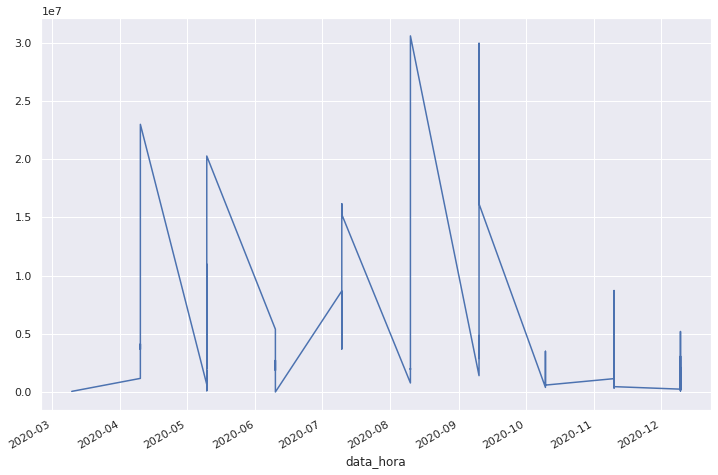

In [174]:
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
import seaborn as sns

%matplotlib inline

plt.figure(figsize=(12, 8))
data = invest_covidPe.gastos
data.plot()

#### **Agregação de dados para visualização**

**Método**:
  * `resample`: *data aggregation*

**Amostragem**:
  * *Semanal* ('5D')
  * *Mensal* ('BM')
  * *Bimestre* ('91D')

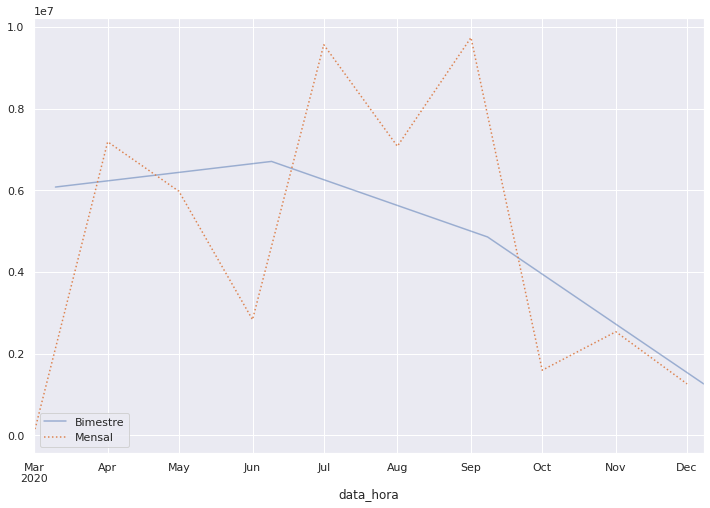

In [175]:
plt.figure(figsize=(12, 8))
data.resample('91D').mean().plot(alpha=0.5, style='-')
data.resample('BM').mean().plot(style=':')
plt.legend(['Bimestre', 'Mensal'], loc='lower left');

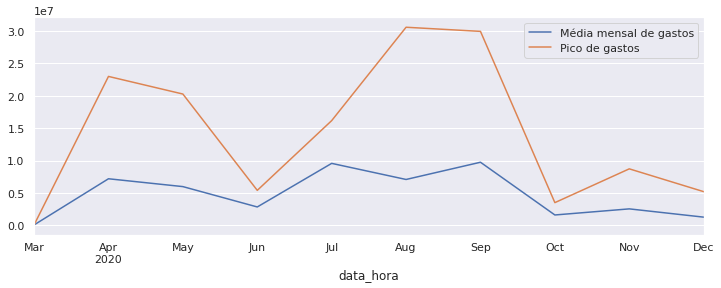

In [169]:
plt.figure(figsize=(12, 4))
data.resample('BM').mean().plot(label='Média mensal de gastos')
data.resample('BM').max().plot(label='Pico de gastos')
plt.legend()

### Janela deslizante

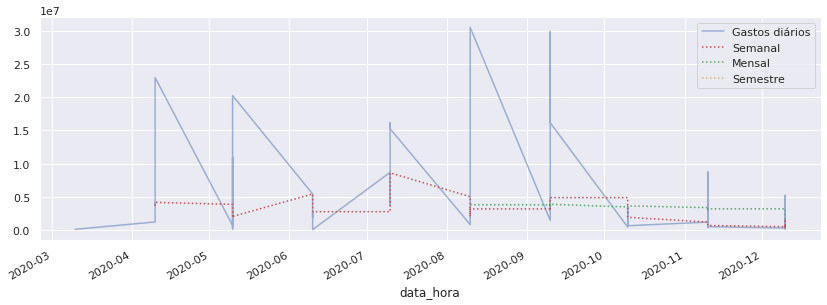

In [177]:
plt.figure(figsize=(14, 10))

plt.subplot(211)
data.rolling(1).median().plot(label='Gastos diários' , alpha=.5)
(data.rolling(5)
 .median()
 .plot(label="Semanal", style='r:', alpha=1)
)
(data.rolling(30)
 .median()
 .plot(label="Mensal", style='g:', alpha=1)
)
(data.rolling(91)
 .median()
 .plot(label="Semestre", style='y:', alpha=1)
)
plt.legend()

#### Previsões com Prophet

> Realizaremos previsões de gastos semanal, mensal e anual em relação ao estado de pernambuco com o agravamento da covid-19

> O conjunto histórico se dará com o todo o conjunto de dados de Março/2020 até Dezembro/2020

A intenção é avaliar se a previsão corresponde com os meses já passados de 2021 e com os próximos meses até o final do ano.

In [156]:
!pip install --quiet fbprophet

In [179]:
invest_covidPe['Tipo'] = invest_covidPe['Tipo'].cat.codes
invest_covidPe['favorecido'] = invest_covidPe['favorecido'].cat.codes
invest_covidPe['UF'] = invest_covidPe['UF'].cat.codes
invest_covidPe['municipio'] = invest_covidPe['municipio'].cat.codes
invest_covidPe['funcao'] = invest_covidPe['funcao'].cat.codes
invest_covidPe['prog_ocamentario'] = invest_covidPe['prog_ocamentario'].cat.codes
invest_covidPe['acao_orcamentaria'] = invest_covidPe['acao_orcamentaria'].cat.codes

Para avaliação do melhor resultado para remoção de outliers, serão utilizados 
cópias dos dataframes gerados

In [180]:
invest_covidPe_forest = invest_covidPe

In [181]:
print("Quantidade de linhas: " + str(len(invest_covidPe)))

Quantidade de linhas: 59


#### Isolation Forest

In [182]:
from sklearn.ensemble import IsolationForest
rng = np.random.RandomState(42)
clf = IsolationForest(max_samples=100, random_state=rng)
clf.fit(invest_covidPe_forest)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_iforest.py:281: UserWarning:

max_samples (100) is greater than the total number of samples (59). max_samples will be set to n_samples for estimation.



IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples=100, n_estimators=100,
                n_jobs=None,
                random_state=RandomState(MT19937) at 0x7F81AB2EED10, verbose=0,
                warm_start=False)

In [183]:
scores = clf.predict(invest_covidPe_forest)

In [184]:
scores

array([-1,  1,  1,  1,  1,  1, -1,  1,  1, -1, -1,  1, -1,  1,  1,  1,  1,
       -1,  1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
       -1, -1,  1,  1,  1,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1])

In [185]:
invest_covidPe_forest['outlier'] = scores
print(invest_covidPe_forest.head())

            Tipo  favorecido  UF  ...      gastos  log_gastos  outlier
data_hora                         ...                                 
2020-03-10     0           1   0  ...    60000.00    4.778151       -1
2020-04-10     0           1   0  ...  1174944.27    6.070017        1
2020-04-10     0           1   0  ...  4130446.89    6.615997        1
2020-04-10     0           1   0  ...  3830136.03    6.583214        1
2020-04-10     0           1   0  ...  3662675.00    6.563798        1

[5 rows x 10 columns]


In [186]:
invest_covidPe_forest[invest_covidPe_forest['outlier'] == -1]

Tipo  favorecido  UF  ...       gastos  log_gastos  outlier
data_hora                         ...                                  
2020-03-10     0           1   0  ...     60000.00    4.778151       -1
2020-04-10     0           1   0  ...  22986081.76    7.361465       -1
2020-05-10     0           1   0  ...    116254.15    5.065408       -1
2020-05-10     0           1   0  ...  10974866.54    7.040399       -1
2020-05-10     0           1   0  ...  20266709.47    7.306783       -1
2020-06-10     0           1   0  ...     10000.00    4.000000       -1
2020-07-10     0           1   0  ...   8589857.00    6.933986       -1
2020-07-10     0           1   0  ...  16162408.00    7.208506       -1
2020-07-10     0           1   0  ...  15246805.00    7.183179       -1
2020-08-10     0           1   0  ...  30578797.00    7.485420       -1
2020-09-10     0           1   0  ...  29940189.53    7.476255       -1
2020-09-10     0           1   0  ...  16156268.66    7.208341       -1
2020-11-10     0           1   0  ...    486515.00    5.687096       -1
2020-11-10     0           0   0  ...   8716731.90    6.940354       -1

[14 rows x 10 columns]

In [187]:
invest_covidPe_forest = invest_covidPe_forest[invest_covidPe_forest['outlier'] != -1]
len(invest_covidPe_forest)

45

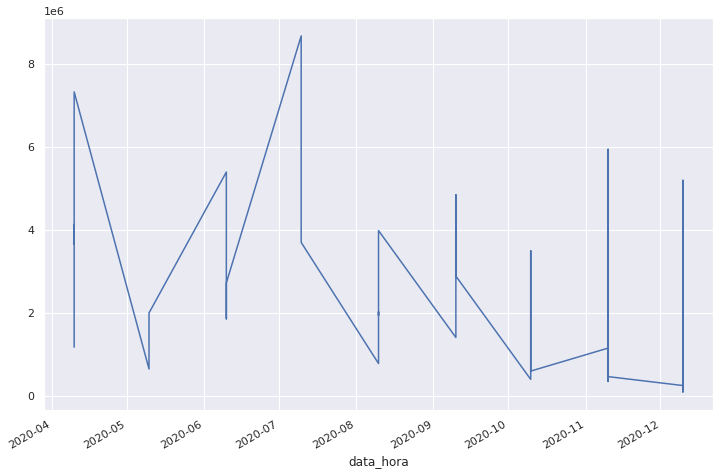

In [189]:
%matplotlib inline

plt.figure(figsize=(12, 8))
data = invest_covidPe_forest.gastos
data.plot()

In [190]:
from fbprophet import Prophet

prophet_df = data.reset_index()
prophet_df.columns = ["ds", "y"]
prophet_df.tail()

ds           y
40 2020-12-10  1016127.00
41 2020-12-10  3084001.00
42 2020-12-10   180590.25
43 2020-12-10   696168.00
44 2020-12-10   211638.00

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


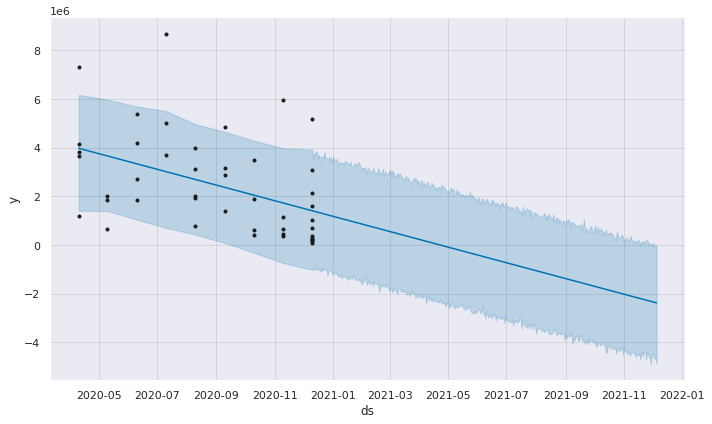

In [191]:
m = Prophet()
m.fit(prophet_df)
pred = m.predict(m.make_future_dataframe(periods=360))
m.plot(pred); # weird bug causes to plot twice, put ; in the end

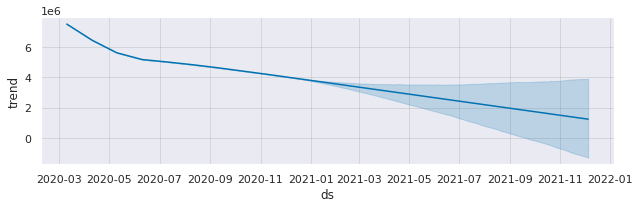

In [160]:
m.plot_components(pred);

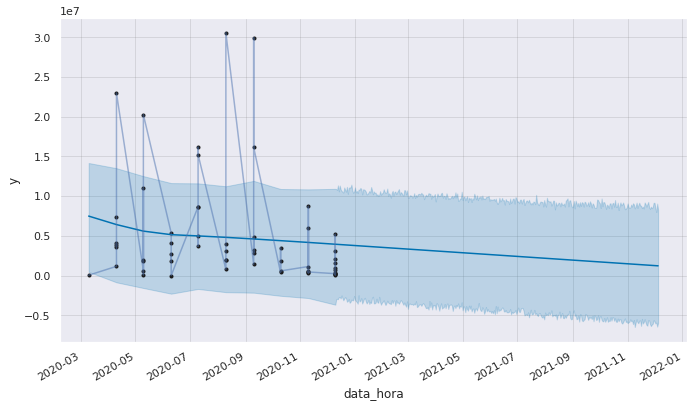

In [161]:
m.plot(pred); # weird bug causes to plot twice, put ; in the end
data.plot(label='Gastos (em milhões)', alpha=.5)